In [ ]:
#Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import norm
from datetime import datetime
from sklearn.impute import SimpleImputer
from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
!pip install hpsklearn

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.4 MB/s eta 0:00:00
  Created wheel for hpsklearn: filename=hpsklearn-0.1.0-py3-none-any.whl size=23911 sha256=44421711f2673d6c3edfa77810b28fe0c149e2b8406e9917910c6307d2c38cea
  Stored in directory: /root/.cache/pip/wheels/17/c9/77/c90583ead12766888d5bd1287f1a459a96c0de450ded17f6d5
Successfully built hpsklearn


In [ ]:
!pip install --upgrade hyperopt numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 30.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2


In [ ]:
training_set = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/training_OH.csv', low_memory=False)

In [ ]:
validation_set = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/validation_OH.csv', low_memory=False)

In [ ]:
test_set = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/test_OH.csv', low_memory=False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define features and target variable for training set
X_train = training_set.drop(columns=['ID', 'Global_Score_pro'])
y_train = training_set['Global_Score_pro']

# Define features and target variable for validation set
X_valid = validation_set.drop(columns=['ID', 'Global_Score_pro'])
y_valid = validation_set['Global_Score_pro']

# Initialize the Random Forest Regressor with max_depth=5
rf_regressor = RandomForestRegressor()

# Train the Random Forest Regressor on the training set
rf_regressor.fit(X_train, y_train)

# Predict on training set
y_pred_train = rf_regressor.predict(X_train)

# Predict on validation set
y_pred_valid = rf_regressor.predict(X_valid)

# Calculate Mean Squared Error (MSE) on training set
mse_train = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error (MSE) on training set:", mse_train)

# Calculate Mean Squared Error (MSE) on validation set
mse_valid = mean_squared_error(y_valid, y_pred_valid)
print("Mean Squared Error (MSE) on validation set:", mse_valid)


Mean Squared Error (MSE) on training set: 48.76874044979755
Mean Squared Error (MSE) on validation set: 382.5951086830084


In [ ]:
from hpsklearn import HyperoptEstimator, random_forest_regression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor  # Add this import

# Define features and target variable for training set
X_train = training_set.drop(columns=['ID', 'Global_Score_pro'])
y_train = training_set['Global_Score_pro']

# Define features and target variable for validation set
X_valid = validation_set.drop(columns=['ID', 'Global_Score_pro'])
y_valid = validation_set['Global_Score_pro']

seed=42
max_evals = 50
def objective(params):
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    msl=int(params['min_samples_leaf'])
    mss=int(params['min_samples_split'])
    model=RandomForestRegressor(n_estimators=est,max_depth=md,min_samples_leaf=msl,min_samples_split=mss)
    model.fit(X_train,y_train)
    pred=model.predict(X_valid)
    score=mean_squared_error(y_valid ,pred)
    return score

def optimize(trial):
    params={'n_estimators':hp.uniform('n_estimators',100,200),
           'max_depth':hp.uniform('max_depth',5,20),
           'min_samples_leaf':hp.uniform('min_samples_leaf',1,5),
           'min_samples_split':hp.uniform('min_samples_split',2,6)}
    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=max_evals,rstate=np.random.default_rng(seed),catch_eval_exceptions=True)
    return best

trial=Trials()
best=optimize(trial)




100%|██████████| 50/50 [9:07:18<00:00, 656.77s/trial, best loss: 389.9880319354644]


In [ ]:
print (best)

{'max_depth': 19.179190872319612, 'min_samples_leaf': 2.845764232660709, 'min_samples_split': 3.0786618112956368, 'n_estimators': 186.3955408579364}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define features and target variable for training set
X_train = training_set.drop(columns=['ID', 'Global_Score_pro'])
y_train = training_set['Global_Score_pro']

# Define features and target variable for validation set
X_valid = validation_set.drop(columns=['ID', 'Global_Score_pro'])
y_valid = validation_set['Global_Score_pro']

# Define the parameter distribution for hyperparameter tuning
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None] + list(range(5, 20)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Perform Randomized Search Cross-Validation to find the best hyperparameters
random_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_dist,
                                   scoring='neg_mean_squared_error', n_iter=10, cv=3, n_jobs=-1, verbose=2,
                                   random_state=42)

random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best model to make predictions on the validation set
best_rf_model = random_search.best_estimator_
y_pred_valid = best_rf_model.predict(X_valid)

# Evaluate the best model on the validation set
mse_valid = mean_squared_error(y_valid, y_pred_valid)
print("Mean Squared Error (MSE) on validation set (Best Model):", mse_valid)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 13, 'min_samples_leaf': 16, 'min_samples_split': 16, 'n_estimators': 100}
Mean Squared Error (MSE) on validation set (Best Model): 410.30928586524874


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define features and target variable for training set
X_train = training_set.drop(columns=['ID', 'Global_Score_pro'])
y_train = training_set['Global_Score_pro']

# Define features and target variable for validation set
X_valid = validation_set.drop(columns=['ID', 'Global_Score_pro'])
y_valid = validation_set['Global_Score_pro']

# Initialize the RandomForestRegressor with best hyperparameters
rf_regressor = RandomForestRegressor(bootstrap=True, max_depth=13, min_samples_leaf=16,
                                     min_samples_split=16, n_estimators=100,
                                     random_state=42)

# Train the RandomForestRegressor on the training set
rf_regressor.fit(X_train, y_train)

# Predict on training set
y_pred_train = rf_regressor.predict(X_train)

# Predict on validation set
y_pred_valid = rf_regressor.predict(X_valid)

# Calculate Mean Squared Error (MSE) on training set
mse_train = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error (MSE) on training set:", mse_train)

# Calculate Mean Squared Error (MSE) on validation set
mse_valid = mean_squared_error(y_valid, y_pred_valid)
print("Mean Squared Error (MSE) on validation set (Best Model):", mse_valid)


Mean Squared Error (MSE) on training set: 355.18415006828195
Mean Squared Error (MSE) on validation set (Best Model): 414.80164809793604


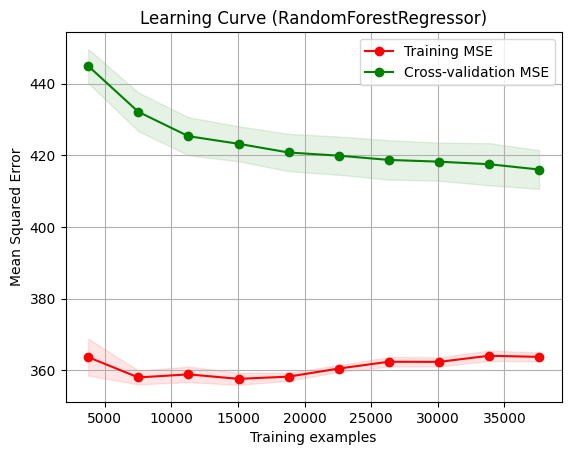

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# Define a function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training MSE")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation MSE")

    plt.legend(loc="best")
    return plt

# Define the maximum number of training samples
max_training_samples = 47000

# Define the range of training sizes
training_sizes = np.linspace(0.1, 1.0, 10)

# Plot learning curve
title = "Learning Curve (RandomForestRegressor)"
plot_learning_curve(rf_regressor, title, X_train[:max_training_samples], y_train[:max_training_samples],
                    cv=5, n_jobs=-1, train_sizes=training_sizes)

plt.show()


In [ ]:
# Define features and target variable for training set
X_train = training_set.drop(columns=['ID', 'Global_Score_pro'])
y_train = training_set['Global_Score_pro']

# Define features and target variable for validation set
X_valid = validation_set.drop(columns=['ID', 'Global_Score_pro'])
y_valid = validation_set['Global_Score_pro']


# Define hyperparameters
hyperparameters = {'max_depth': 19,
                   'min_samples_leaf': 3,
                   'min_samples_split': 3,
                   'n_estimators': 186}

# Train Random Forest Regressor with specified hyperparameters
model_rf = RandomForestRegressor(random_state=42, **hyperparameters)
model_rf.fit(X_train, y_train)


# Predict on training set
y_pred_train_rf = model_rf.predict(X_train)

# Predict on validation set
y_pred_valid_rf = model_rf.predict(X_valid)


# Calculate Mean Squared Error (MSE) on training set
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
print("Mean Squared Error (MSE) on training set:", mse_train_rf)

# Calculate MSE on validation set
mse_valid_rf = mean_squared_error(y_valid, y_pred_valid_rf)
print("Mean Squared Error (MSE) on validation set with Random Forest:", mse_valid_rf)


Mean Squared Error (MSE) on training set: 254.90412770717373
Mean Squared Error (MSE) on validation set with Random Forest: 389.83282701632965


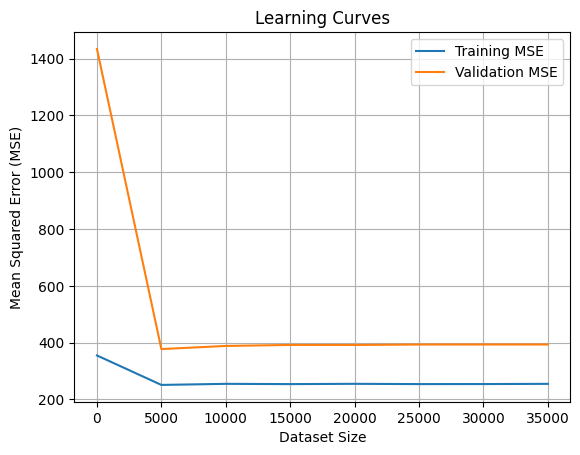

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define the maximum number of instances to consider
max_instances = 40000

# Define a range of instance sizes for the datasets
dataset_sizes = np.arange(1, min(len(X_train), len(X_valid), max_instances) + 1, 5000)  # From 1 to the min of dataset size or max_instances with steps of 500

# Initialize lists to store MSE values for each set
mse_train_sizes = []
mse_valid_sizes = []

# Loop over different sizes of instances for the datasets
for size in dataset_sizes:
    # Subset the training and validation sets to the current size
    X_train_subset = X_train[:size]
    y_train_subset = y_train[:size]
    X_valid_subset = X_valid[:size]
    y_valid_subset = y_valid[:size]

    # Predict on training set
    y_pred_train = model_rf.predict(X_train_subset)

    # Predict on validation set
    y_pred_valid = model_rf.predict(X_valid_subset)

    # Calculate MSE for training set
    mse_train = mean_squared_error(y_train_subset, y_pred_train)

    # Calculate MSE for validation set
    mse_valid = mean_squared_error(y_valid_subset, y_pred_valid)

    # Append MSE values for both training and validation sets
    mse_train_sizes.append(mse_train)
    mse_valid_sizes.append(mse_valid)

# Plot learning curves
plt.plot(dataset_sizes, mse_train_sizes, label='Training MSE')
plt.plot(dataset_sizes, mse_valid_sizes, label='Validation MSE')

plt.title('Learning Curves')
plt.xlabel('Dataset Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Define features and target variable for test set
X_test = test_set.drop(columns=['ID', 'Global_Score_pro'])
y_test = test_set['Global_Score_pro']

# Predict on test set
y_pred_test = model_rf.predict(X_test)

# Calculate Mean Squared Error (MSE) on test set
mse_test = mean_squared_error(y_test, y_pred_test)
print("Mean Squared Error (MSE) on test set:", mse_test)


Mean Squared Error (MSE) on test set: 390.5096488081295


Mean Squared Error (MSE) on test set: 390.5096488081295


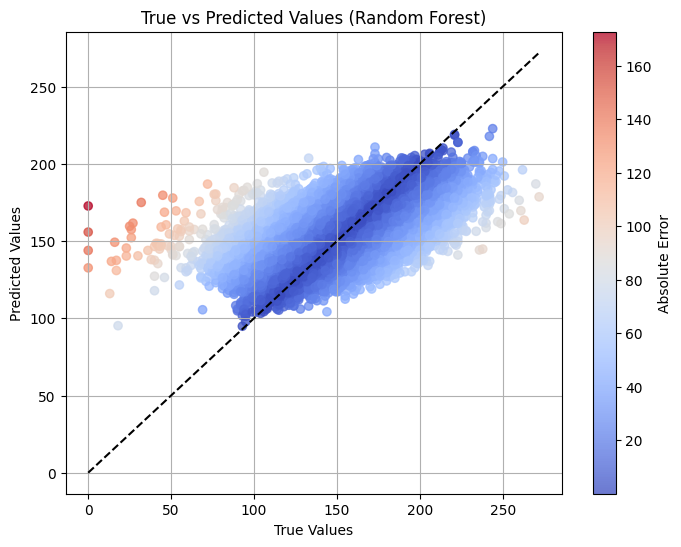

In [ ]:
y_true = y_test  # True values
y_pred = y_pred_test  # Predicted values

# Calculate Mean Squared Error (MSE) on test set
mse_test = mean_squared_error(y_true, y_pred)
print("Mean Squared Error (MSE) on test set:", mse_test)

# Calculate the colors based on the magnitude of the true values
colors = np.abs(y_true - y_pred)

# Plotting true values vs predicted values with color mapping
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, c=colors, cmap='coolwarm', alpha=0.75)
plt.colorbar(label='Absolute Error')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='black', linestyle='--')
plt.title('True vs Predicted Values (Random Forest)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [ ]:
noise_factor = 0.1
X_test_noisy = X_test + noise_factor * np.random.normal(size=X_test.shape)

# Predict on noisy test set
y_test_pred_noisy = model_rf.predict(X_test_noisy)

# Calculate Mean Squared Error (MSE) on noisy test set
mse_test_noisy = mean_squared_error(y_test, y_test_pred_noisy)
print("Mean Squared Error (MSE) on noisy test set:", mse_test_noisy)

Mean Squared Error (MSE) on noisy test set: 390.5053532800224


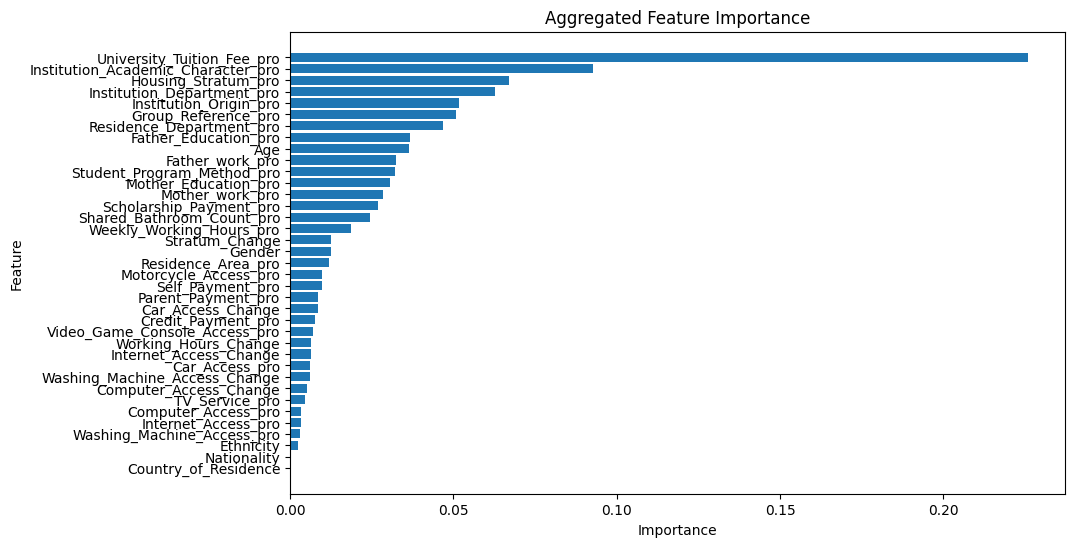

In [ ]:
# Extract feature importance
feature_importance = model_rf.feature_importances_

# Get the names of features
feature_names = X_test.columns

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Modify the feature names to remove the prefix 'one_hot_encoder__' if present
feature_importance_df['Feature'] = feature_importance_df['Feature'].apply(lambda x: x.replace('one_hot_encoder__', '').rsplit('_', 1)[0])

# Aggregate feature importance
aggregated_importance = feature_importance_df.groupby('Feature').sum()

# Sort aggregated feature importance
aggregated_importance = aggregated_importance.sort_values(by='Importance', ascending=False)

# Plot aggregated feature importance
plt.figure(figsize=(10, 6))
plt.barh(aggregated_importance.index, aggregated_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Aggregated Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Save the predictions and the true values to a CSV file
test_results_rf = pd.DataFrame({
    'ID': test_set['ID'],
    'True Values': y_test,
    'Predictions': y_pred_test
})

In [ ]:
test_results_rf.to_csv('/content/drive/MyDrive/Colab Notebooks/predictions_rf.csv', index=False)

In [ ]:
pip install dalex -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.0-py3-none-any.whl size=1042471 sha256=b7709418e71cb831163c3a863cb0582fcdba2b7092a5add0b376a187cac13c4c
  Stored in directory: /root/.cache/pip/wheels/e2/38/c1/25a95206a4873a287d776fc8e77aa7d93971acc643ecb3db38
Successfully built dalex


In [ ]:
import dalex as dx
print(dx.__version__)

1.7.0


In [ ]:
exp = dx.Explainer(model_rf, X_test, y_test, verbose=False)

In [ ]:
print(exp)

In [ ]:
mp = exp.model_performance()
print("Model Performance:")
print(mp.result)

Model Performance:
                              mse       rmse        r2        mae        mad
RandomForestRegressor  390.509649  19.761317  0.400912  15.175023  12.255392


In [ ]:
protected_gender = np.where(X_test['one_hot_encoder__Gender_F'] == 1, 'Female', 'Male')
privileged_gender = 'Male'  # Privileged group is everything not in the protected group

fobject1 = exp.model_fairness(protected_gender , privileged_gender)
fobject1.fairness_check()


No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on 'Male'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
          independence  separation  sufficiency
subgroup                                       
Female        1.045401    1.021846     1.000676


In [ ]:
protected_ethnicity = np.where(X_test['one_hot_encoder__Ethnicity_Ninguno'] == 0, 'Ethnicity', 'Else')
privileged_ethncity = 'Else'  # Privileged group is everything not in the protected group

fobject2 = exp.model_fairness(protected_ethnicity , privileged_ethncity)
fobject2.fairness_check()

Bias detected in 1 metrics: independence

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Else'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
           independence  separation  sufficiency
subgroup                                        
Ethnicity      1.387004    1.161138     1.013641


In [ ]:
fobject1.plot()

In [ ]:
fobject2.plot()